In [41]:
import librosa
import os, gc
import numpy as np
import random
import itertools

import pandas as pd

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import matplotlib.pyplot as plt

from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

In [3]:
PROJECT_PATH='/home/hmenn/Workspace/CSE455_MachineLearning_2018/Final_MusicClassification'

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6,6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [5]:
def extractMfccFeature(_path=None, _offset=12, _duration=6):
    try:
        # returns signal and sample rate
        signal, sr = librosa.load(path=_path, offset=_offset, duration=_duration)
                
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        l = mfccs.shape[1]
        mfccs = mfccs[:, int(0.2 * l):int(0.8 * l)]

        mean = mfccs.mean(axis=1)
        covar = np.cov(mfccs, rowvar=1)

        mean.resize(1, mean.shape[0])
        # it returns matrix.. not useful for machine learning algorithms except KNN
        npArray = np.concatenate((mean, covar), axis=0)
        return npArray.flatten()
    except Exception as e:
        print ("Error accured" + str(e))
        return None

In [43]:
music_type_id = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
     'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
music_type_str = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

In [7]:
%%time
walk_dir = "genres"

all_input_data = []
all_input_class = []

for root, subdirs, files in os.walk(walk_dir):
    print("Walk on dir:",root,'Total File:',len(files))
    for filename in files:
        if filename.endswith('.au'):
            file_path = os.path.join(root, filename)
            feature = extractMfccFeature(file_path)

            all_input_data.append(feature)
            all_input_class.append(music_type_id[filename.split('.')[0]])

Walk on dir: genres Total File: 0
Walk on dir: genres/pop Total File: 100
Walk on dir: genres/blues Total File: 100
Walk on dir: genres/classical Total File: 100
Walk on dir: genres/country Total File: 100
Walk on dir: genres/hiphop Total File: 100
Walk on dir: genres/rock Total File: 100
Walk on dir: genres/reggae Total File: 100
Walk on dir: genres/metal Total File: 100
Walk on dir: genres/disco Total File: 100
Walk on dir: genres/jazz Total File: 100
CPU times: user 8min 5s, sys: 4min 21s, total: 12min 27s
Wall time: 7min 22s


### Shuffling all data

In [44]:
%%time
print("Shuffle input data to get better results")

all_input_shuffledData = np.asarray(all_input_data)
all_input_shuffledClass = np.asarray(all_input_class)

s = np.arange(all_input_shuffledData.shape[0])
np.random.shuffle(s)

all_input_shuffledData = all_input_shuffledData[s]
all_input_shuffledClass = all_input_shuffledClass[s]

print("->all_input_shuffledData:",all_input_shuffledData.shape)
print("->all_input_shuffledClass:",all_input_shuffledClass.shape)

Shuffle input data to get better results
->all_input_shuffledData: (1000, 420)
->all_input_shuffledClass: (1000,)
CPU times: user 5.45 ms, sys: 353 µs, total: 5.8 ms
Wall time: 7.46 ms


In [91]:
%%time
yt_data = []
yt_class = []

# CLASSICAL 
print('Classical')
classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=65, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=180, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=255, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=365, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=540, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

# JAZZ
print('Jazz')
jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=140, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=360, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=570, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=275, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])
 
# POP
print('Pop')
pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=10, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=170, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=280, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=645, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=1020, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

# BLUES
print('Blues')
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=75, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=450, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=680, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=635 , _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=1230, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

# ROCK(GOOD)
print('Rock')
rock = extractMfccFeature(PROJECT_PATH+'/test/rock.mp3', _offset=220, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rock.mp3', _offset=350, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rock.mp3', _offset=580, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rock.mp3', _offset=760, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rock.mp3', _offset=1045, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])


# HIP HOP
print('HipHop')
hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=5, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=28, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=20, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=12, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop']) 

# DISCO
print('Disco')
disco = extractMfccFeature(PROJECT_PATH+'/test/disco.mp3', _offset=20, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.mp3', _offset=360, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.mp3', _offset=490, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.mp3', _offset=850, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.mp3', _offset=940, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

# COUNTRY (GOOD)
print('Country')
country = extractMfccFeature(PROJECT_PATH+'/test/country.mp3', _offset=45 , _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.mp3', _offset=360, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.mp3', _offset=565, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.mp3', _offset=680, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.mp3', _offset=445, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

# REGGAE(GOOD)
print('Reggae')
reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=65, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=660, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=845, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=1200, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=1435, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae']) 

# METAL(Good)
print('Metal')
metal = extractMfccFeature(PROJECT_PATH+'/test/metal.mp3', _offset=20, _duration=6)
yt_data.append(metal)
yt_class.append(music_type_id['metal'])

metal = extractMfccFeature(PROJECT_PATH+'/test/metal.mp3', _offset=190, _duration=6)
yt_data.append(metal)
yt_class.append(music_type_id['metal'])

metal = extractMfccFeature(PROJECT_PATH+'/test/metal.mp3', _offset=290, _duration=6)
yt_data.append(metal)
yt_class.append(music_type_id['metal'])

metal = extractMfccFeature(PROJECT_PATH+'/test/metal.mp3', _offset=500, _duration=6)
yt_data.append(metal)
yt_class.append(music_type_id['metal'])

metal = extractMfccFeature(PROJECT_PATH+'/test/metal.mp3', _offset=970, _duration=6)
yt_data.append(metal)
yt_class.append(music_type_id['metal'])

Classical
Jazz
Pop
Blues
Rock
HipHop
Disco
Country
Reggae
Metal
CPU times: user 2min 30s, sys: 22.4 s, total: 2min 52s
Wall time: 3min 13s


### KNN

KNN Score:  0.365
KNN Youtube Score:  0.4375
CPU times: user 986 ms, sys: 287 ms, total: 1.27 s
Wall time: 903 ms


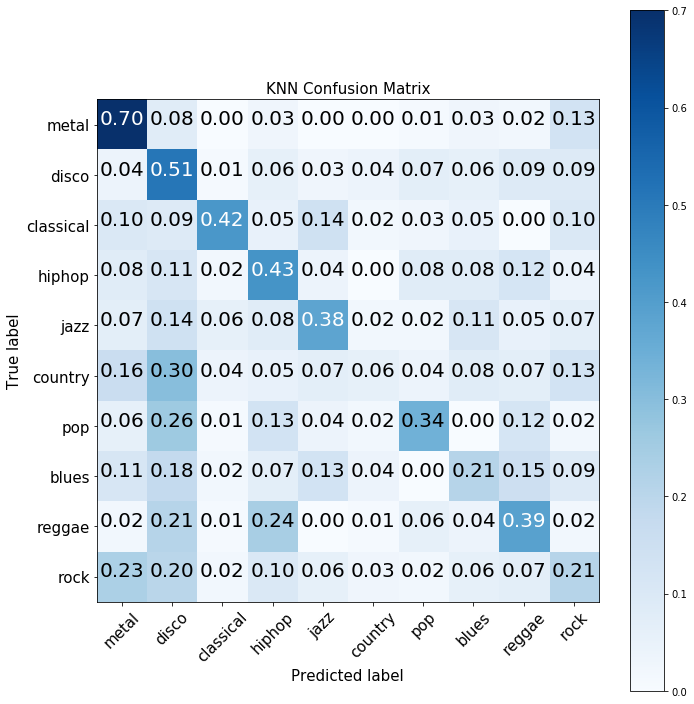

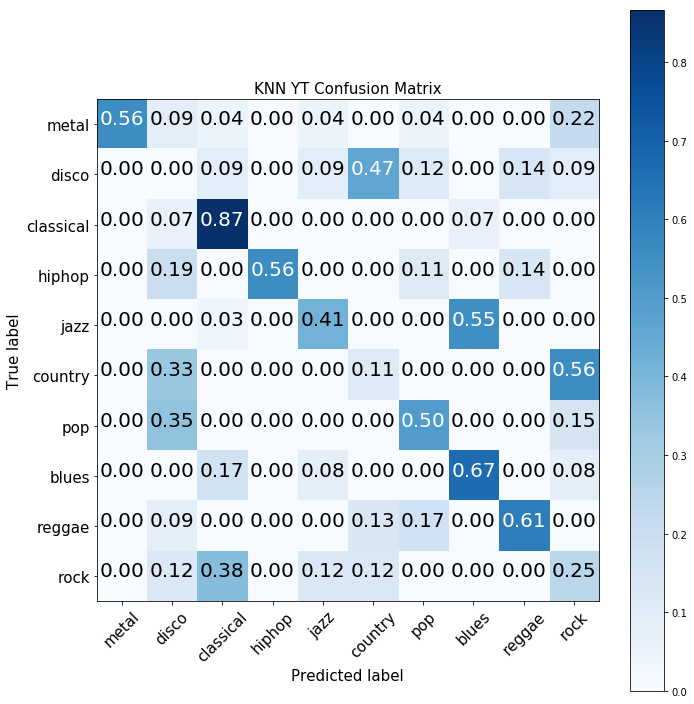

In [103]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(knn.predict(X_test))

    yt_guess.extend(knn.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)

plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KNN Confusion Matrix', figsize=(10,10))
print("KNN Score: ", accuracy_score(actual, guess))


coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KNN YT Confusion Matrix',figsize=(10,10))
print("KNN Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### SVM

SVM Score:  0.499
SVM Youtube Score:  0.2625
CPU times: user 18.3 s, sys: 216 ms, total: 18.5 s
Wall time: 18.3 s


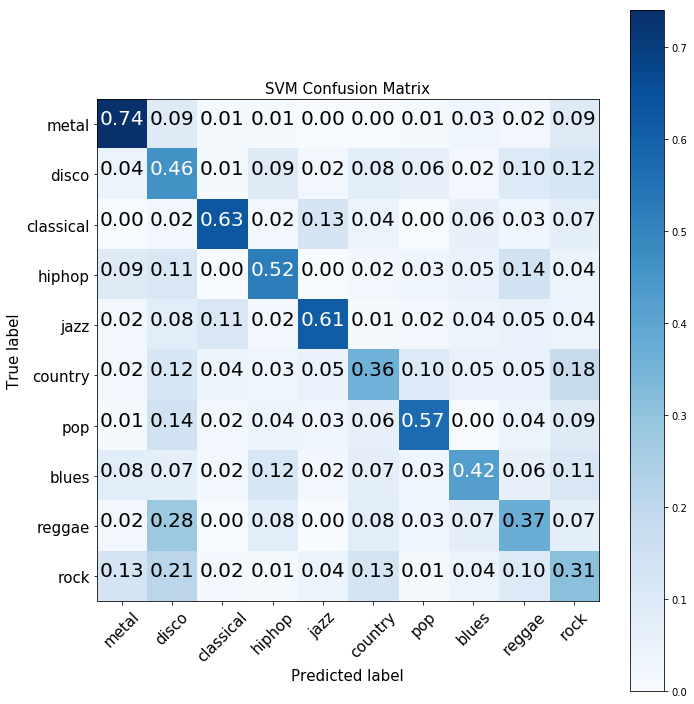

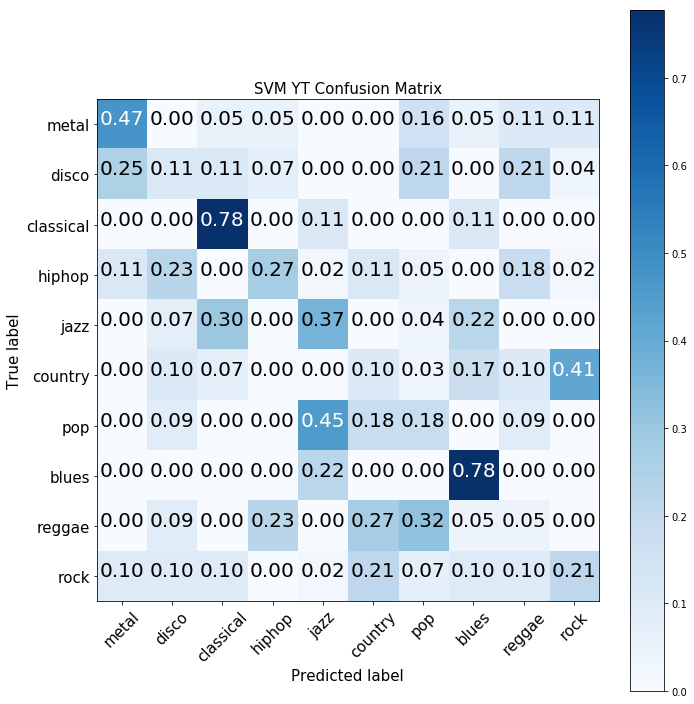

In [104]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(svm1.predict(X_test))

    yt_guess.extend(svm1.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='SVM Confusion Matrix',figsize=(10,10))
print("SVM Score: ", accuracy_score(actual, guess))


coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='SVM YT Confusion Matrix',figsize=(10,10))
print("SVM Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### Decision Tree

Decision Tree Score:  0.376
Decision Youtube Score:  0.3
CPU times: user 2.05 s, sys: 273 ms, total: 2.32 s
Wall time: 1.97 s


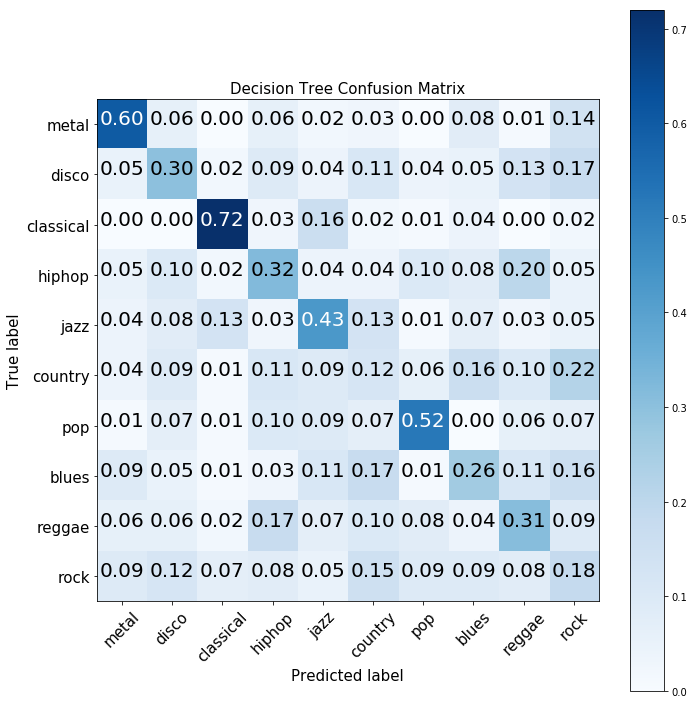

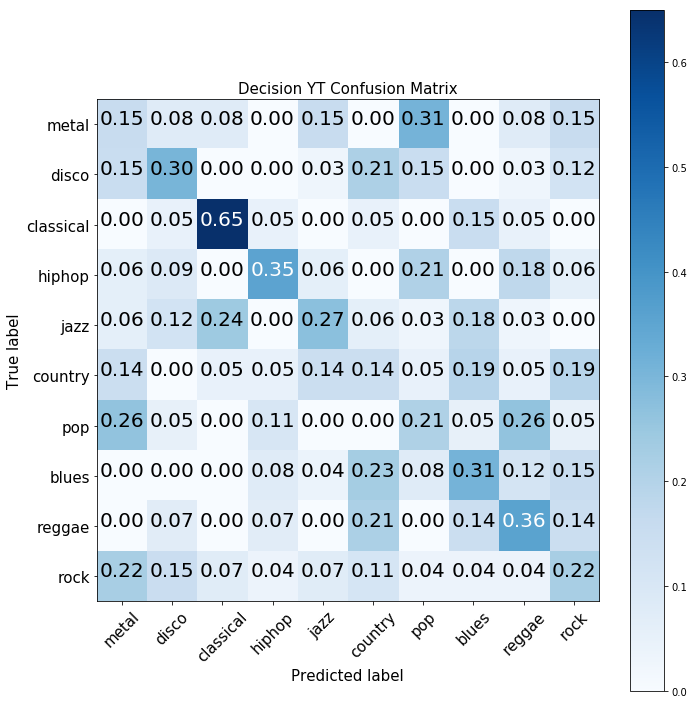

In [107]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Decision Tree Confusion Matrix',figsize=(10,10))        
print("Decision Tree Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Decision YT Confusion Matrix',figsize=(10,10))
print("Decision Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### XGBoost

XGBoost Accuracy Score: 0.6
XGBoost Youtube Score:  0.425
CPU times: user 8min 48s, sys: 2.06 s, total: 8min 50s
Wall time: 2min 29s


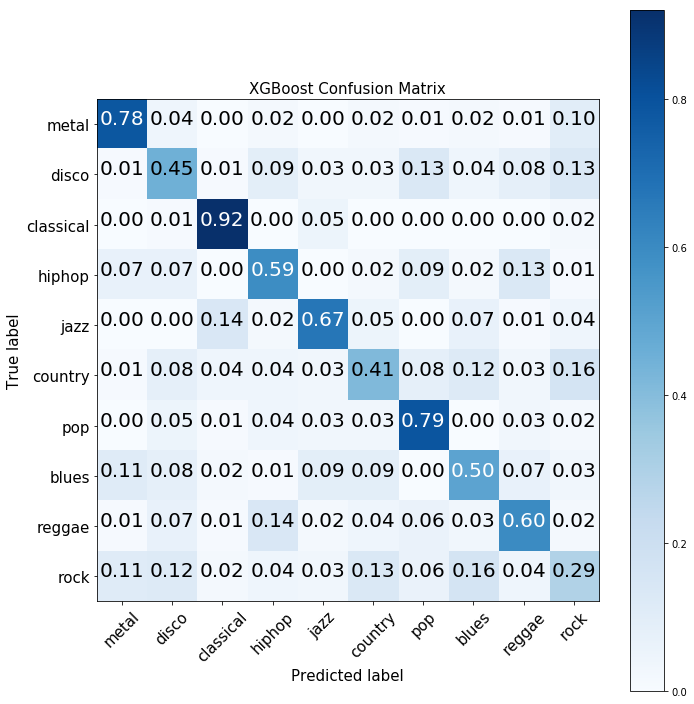

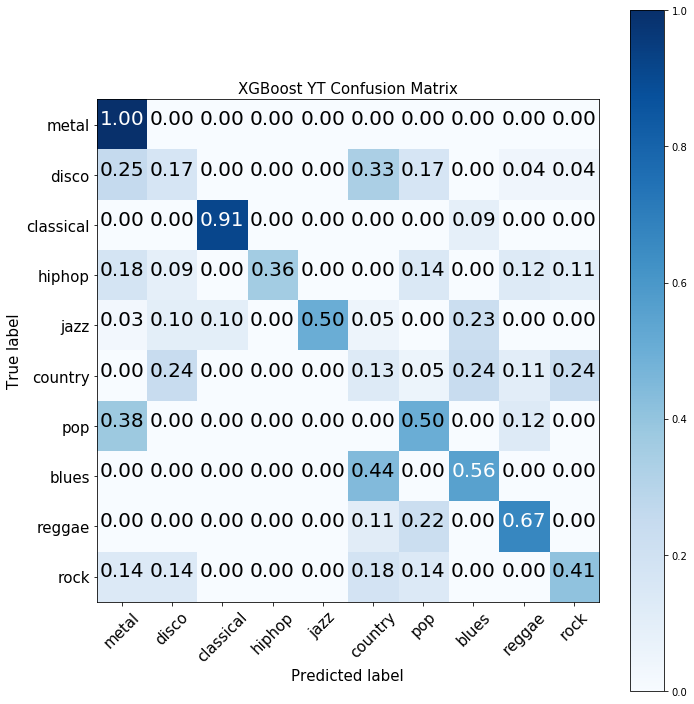

In [105]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, d_train, num_boost_round = 240)
    
    actual.extend(y_test)
    guess.extend(model.predict(d_valid))
    
    d_yt = xgb.DMatrix(yt_data, yt_class)
    yt_guess.extend(model.predict(d_yt))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='XGBoost Confusion Matrix',figsize=(10,10))
print('XGBoost Accuracy Score:',accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='XGBoost YT Confusion Matrix',figsize=(10,10))
print("XGBoost Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### Random Forest

Random Forest Score:  0.371
Random Forest Youtube Score:  0.3333333333333333
CPU times: user 627 ms, sys: 281 ms, total: 908 ms
Wall time: 557 ms


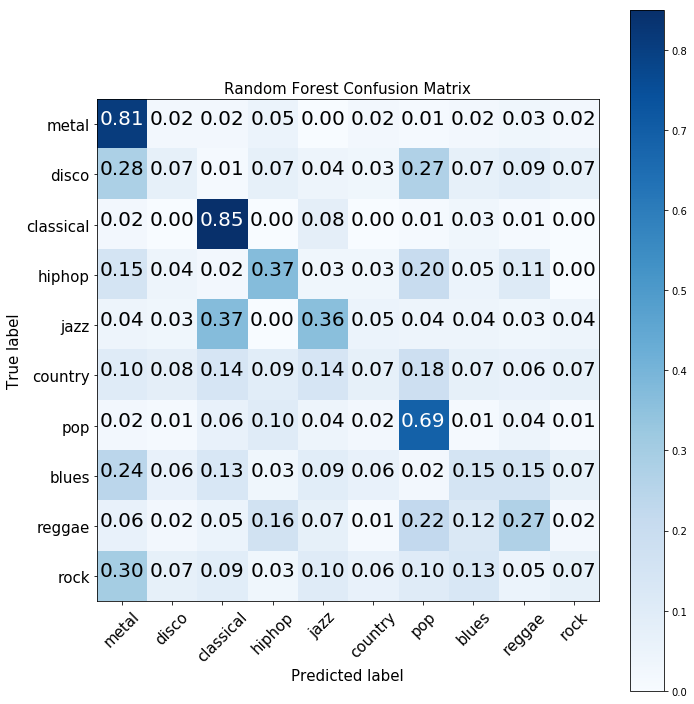

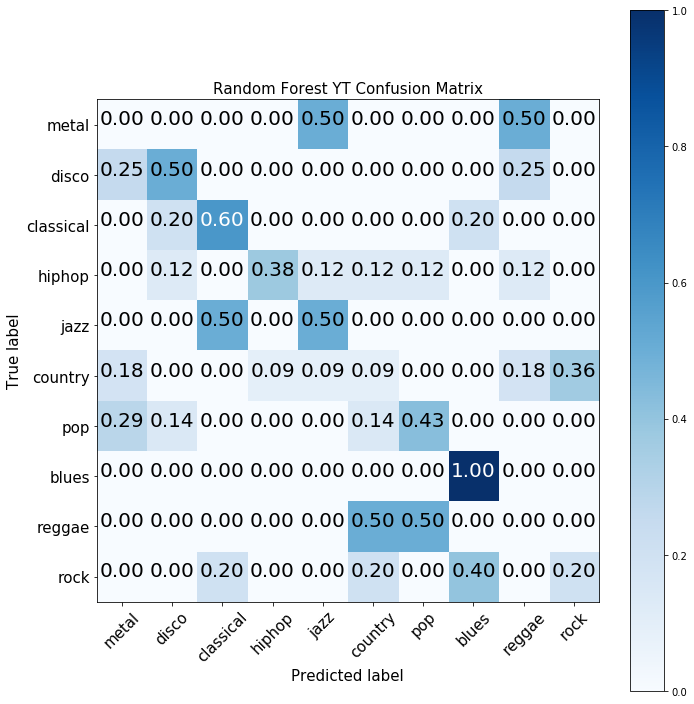

In [106]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    clf = RandomForestClassifier(max_depth=3, random_state=0)
    clf.fit(X_train, y_train)
 
    actual.extend(y_test)
    guess.extend(clf.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Random Forest Confusion Matrix',figsize=(10,10))        
print("Random Forest Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Random Forest YT Confusion Matrix',figsize=(10,10))
print("Random Forest Youtube Score: ", accuracy_score(yt_guess, yt_actual))

In [17]:
# run garbage collector manually
gc.collect()

30197